In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from copy import deepcopy
import heapq

In [2]:
class LIF:
    def __init__(self, R, tau, u_rest, thre, u_spike, u_reset):
        self.dataPass = []
        self.spikes = []
        self.I = []
        self.R = R
        self.tau = tau
        self.u = u_rest
        self.u_rest = u_rest
        self.thre = thre
        self.u_spike = u_spike
        self.u_reset = u_reset

    def action(self, I_func, span, dt, unset=True):
        if not unset:
            pass
        else:
            self.rest()
        size = math.ceil(span / dt)
        u = np.zeros(shape=(size, 2))
        spikes = []
        time = 0
        for idx in range(len(u)):
            u[idx, 1] = self.u
            u[idx, 0] = time
            if self.u <= self.thre:
                pass
            else:
                spikes.append(time)
                self.unset()
            du = dt * (-1 * (self.u - self.u_rest)
                       + 1e-3 * self.R * I_func(time)) / self.tau
            self.u += du
            time += dt
        return {'voltage': u, 'spikes': spikes}

    def one_step(self, input_I, time, dt):
        du = dt * (-1 * (self.u - self.u_rest)
                   + 1e-3 * self.R * input_I) / self.tau

        self.u += du
        time += dt
        self.dataPass.append((self.u, time))
        self.I.append((input_I, time))
        if self.u > self.thre:
            self.spikes.append(time)
            self.unset()

    def unset(self):
        self.u = self.u_reset

    def rest(self):
        self.u = self.u_rest

    def dell(self):
        self.dataPass = []
        self.spikes = []
        self.I = []
        self.u = self.u_rest


In [3]:

class Population:
    def __init__(self, p_type, n_list, time_c, j=20):
        self.p_activity = []
        self.n_list = n_list
        self.c = np.zeros((len(n_list), len(n_list)))
        self.j = j
        self.c_type = self.fully_c
        set_c = self.c_type
        self.p_type = p_type
        set_c()
        self.time_c = time_c
        self.c_history = deepcopy(self.c.ravel())

    def fully_c(self):
        self.c = np.ones_like(self.c) * (self.j / len(self.n_list))
        self.inhibitory_m()

    def cal_activity_history(self, time, dt, threshold):
        activity_list = np.zeros((len(self.n_list), 1))

        for idx in range(len(self.n_list)):
            activity_list[idx, 0] = \
                self.cal_activity_pass_single(idx, time, dt, threshold)
        return activity_list

    def cal_activity_pass_single(self, idx, time, dt, thre):
        neuron = self.n_list[idx]
        s = 0
        activity = 0
        while not self.time_c(s) <= thre:
            if (time - s) in neuron.spikes:
                activity += self.time_c(s)
            s += dt
        return activity

    def one_step(self, input_current,
                 self_activity, time,
                 dt, time_course_thre):

        inputs = self.c.dot(self_activity)
        for i, neuron in enumerate(self.n_list):
            neuron.one_step(input_current + inputs[i, 0], time, dt)
        activity = self.cal_activity_history(time + dt, dt, time_course_thre)
        return activity

    def reset(self, reset_connection=False):
        self.p_activity = []
        if reset_connection:
            set_c = self.c_type
            set_c()
        for n in self.n_list:
            n.dell()

    def inhibitory_m(self):
        if self.p_type == 'inhibitory':
            self.c = -1 * self.c

    def raster_p(self):
        ax = []
        ay = []
        for neuron in self.n_list:
            id = '#' + str(int(np.floor(np.random.rand() * 10000000)))
            for l in neuron.spikes:
                ax.append(l)
                ay.append(id)
        return ax, ay

    def running(self, I_lists, time_interval, step,
                dt_minus, dt_plus, a_minus,
                a_plus, time_course_threshold):
        learn = self.STDP
        time = 0
        activity = np.zeros((len(self.n_list), 1))
        while time <= time_interval:
            inputs = self.c.dot(activity)
            for i, neuron in enumerate(self.n_list):
                neuron.one_step(I_lists[i](time) + inputs[i, 0], time, step)
            activity = self.cal_activity_history(time + step, step, time_course_threshold)
            learn(time + step, dt_minus, dt_plus, a_minus, a_plus)
            time += step

    def STDP(self, time, dt_minus, dt_plus, a_minus, a_plus):
        new_c = deepcopy(self.c)
        for i in range(len(self.n_list)):
            for j in range(len(self.n_list)):
                if i == j:
                    continue

                pre = self.n_list[j]
                post = self.n_list[i]
                if len(pre.spikes) == 0 \
                        or len(post.spikes) == 0 \
                        or post.spikes[len(post.spikes) - 1] != time:
                    pass

                else:
                    if post.spikes[len(post.spikes) - 1] <= pre.spikes[
                        len(pre.spikes) - 1]:
                        continue

                    dt = abs(post.spikes[len(post.spikes) - 1] -
                             pre.spikes[len(pre.spikes) - 1])
                    new_c[i, j] += a_plus * math.exp(-(dt / dt_plus))
                if len(pre.spikes) == 0 \
                        or len(post.spikes) == 0 \
                        or pre.spikes[
                    len(pre.spikes) - 1] != time:
                    continue

                if post.spikes[len(post.spikes) - 1] < pre.spikes[
                    len(pre.spikes) - 1]:
                    dt = abs(post.spikes[len(post.spikes) - 1] -
                             pre.spikes[len(pre.spikes) - 1])
                    new_c[i, j] += a_minus * math.exp(-(dt / dt_minus))
                    if new_c[i, j] < 0:
                        new_c[i, j] = 0

        self.c_history = np.vstack((self.c_history, new_c.ravel()))
        self.c = deepcopy(new_c)


In [4]:
class SNN:
    def __init__(self, n_dim, lif_n_parametr, time_course, tau_tag, tau_dopamine, reward, j=8):
        self.network_dim = n_dim
        self.lif_n_parametr = lif_n_parametr
        self.n_neurons = []
        self.c_list = []
        self.j = j
        self.tau_dopamine = tau_dopamine
        self.tau_tag = tau_tag
        self.tags = []
        self.reward = reward
        self.c_history = []
        self.time_course = time_course
        self.make_nk_neurons()
        self.make_full_connections_c()
        self.d = 0

    def make_full_connections_c(self):
        for i in range(1, len(self.network_dim)):
            self.c_list.append(np.ones((self.network_dim[i - 1], self.network_dim[i])) *
                               self.j + np.random.rand())
            self.c_history.append(deepcopy(self.c_list[-1].ravel()))
            self.tags.append(np.zeros((self.network_dim[i - 1], self.network_dim[i])))

    def make_nk_neurons(self):
        for i in range(len(self.network_dim)):
            neuron_list = []
            for j in range(self.network_dim[i]):
                if not self.lif_n_parametr['random']:
                    neuron_list.append(
                        LIF(
                            self.lif_n_parametr['R'],
                            self.lif_n_parametr['tau'],
                            self.lif_n_parametr['u_rest'],
                            self.lif_n_parametr['threshold'],
                            self.lif_n_parametr['u_spike'],
                            self.lif_n_parametr['u_reset']
                        )
                    )
                else:
                    neuron_list.append(
                        LIF(
                            self.lif_n_parametr['R'] + np.random.rand() *
                            self.lif_n_parametr['rand_change'],
                            self.lif_n_parametr['tau'] + np.random.rand() *
                            self.lif_n_parametr['rand_change'],
                            self.lif_n_parametr['u_rest'] + np.random.rand() *
                            self.lif_n_parametr['rand_change'],
                            self.lif_n_parametr['threshold'] + np.random.rand() *
                            self.lif_n_parametr['rand_change'],
                            self.lif_n_parametr['u_spike'] + np.random.rand() *
                            self.lif_n_parametr['rand_change'],
                            self.lif_n_parametr['u_reset'] + np.random.rand() *
                            self.lif_n_parametr['rand_change']
                        )
                    )
            self.n_neurons.append(deepcopy(neuron_list))

    def compatible(self, x, y, step,
                   epoch_time, step_minus,
                   dt_plus, a_minus, a_plus,
                   time_course_threshold, iter,
                   learn_time):
        template = 0
        lt = learn_time
        for iteration in range(iter):
            idx = np.random.randint(low=0, high=x.shape[0])
            epoch = 0
            while epoch < epoch_time:
                inputs = x[idx]
                for layer in range(len(self.n_neurons)):
                    for i, neuron in enumerate(self.n_neurons[layer]):
                        neuron.one_step(inputs[i], template, step)
                    if layer != len(self.n_neurons) - 1:
                        activities = self.cal_act(layer, template + step, step, time_course_threshold)
                        inputs = activities @ self.c_list[layer]
                flag = False
                if template > lt:
                    flag = True
                    lt += learn_time
                self.get_information(y, idx, template + step, step, step_minus, dt_plus, a_minus, a_plus, learn_time, flag)
                epoch += step
                template += step

    def get_information(self, y, index, time, step, step_minus, dt_plus, a_minus, a_plus, learn_time, flag):
        for shell in range(len(self.c_list)):
            for i in range(len(self.n_neurons[shell])):
                for j in range(len(self.n_neurons[shell + 1])):
                    pre_neuron = self.n_neurons[shell][i]
                    post_neuron = self.n_neurons[shell][j]
                    stdp = 0
                    if len(pre_neuron.spikes) != 0 and len(post_neuron.spikes) != 0 and \
                            post_neuron.spikes[len(post_neuron.spikes) - 1] == time:
                        if post_neuron.spikes[len(post_neuron.spikes) - 1] > pre_neuron.spikes[
                            len(pre_neuron.spikes) - 1]:
                            step = abs(post_neuron.spikes[len(post_neuron.spikes) - 1] -
                                       pre_neuron.spikes[len(pre_neuron.spikes) - 1])
                            stdp += a_plus * math.exp(-(step / dt_plus))

                    if len(pre_neuron.spikes) == 0 or len(post_neuron.spikes) == 0 or pre_neuron.spikes[
                        len(pre_neuron.spikes) - 1] != time:
                        pass
                    else:
                        if post_neuron.spikes[len(post_neuron.spikes) - 1] < pre_neuron.spikes[
                            len(pre_neuron.spikes) - 1]:
                            step = abs(post_neuron.spikes[len(post_neuron.spikes) - 1] -
                                       pre_neuron.spikes[len(pre_neuron.spikes) - 1])
                            stdp += a_minus * math.exp(-(step / step_minus))

                    self.tags[shell][i, j] += step * ((-self.tags[shell][i, j] / self.tau_tag) + stdp)
                    self.c_list[shell][i, j] += step * (self.tags[shell][i, j] * self.d)
                    if self.c_list[shell][i, j] >= 0:
                        continue
                    self.c_list[shell][i, j] = 0

        reward = 0
        if flag:
            actions = np.zeros_like(self.n_neurons[-1])
            for i, neuron in enumerate(self.n_neurons[-1]):
                quantity = 0
                for spike in reversed(neuron.spikes):
                    if spike <= learn_time:
                        continue
                    quantity += 1
                actions[i] = quantity
            if np.argmax(actions) == int(y[index]):
                big_int = heapq.nlargest(2, list(actions))
                if big_int[0] != 0 and (big_int[0] - big_int[1]) / big_int[0] > 0.1:
                    reward += self.reward
                else:
                    reward -= self.reward
            else:
                reward -= self.reward
        self.d += learn_time * ((-self.d / self.tau_dopamine) + reward)
        for i in range(len(self.c_history)):
            self.c_history[i] = np.vstack((self.c_history[i], self.c_list[i].ravel()))

    def cal_act(self, layer, time, dt, time_course_threshold):
        activity_list = np.zeros(self.network_dim[layer])
        for idx in range(self.network_dim[layer]):
            activity_list[idx] = self.cal_act_one(layer, idx, time, dt, time_course_threshold)
        return activity_list

    def cal_act_one(self, layer, index, time, dt, time_course_threshold):
        neuron = self.n_neurons[layer][index]
        S = 0
        activity = 0
        while time_course_threshold < self.time_course(S):
            if (time - S) in neuron.spikes:
                activity += self.time_course(S)
            S += dt
        return activity

    def forestall(self, x, t_interval, dt, t_course_thre):
        out = np.zeros((len(x)))
        for i in range(len(x)):
            self.reset()
            time = 0
            while time < t_interval:
                inputs = x[i]
                for layer in range(len(self.n_neurons)):
                    for k, neuron in enumerate(self.n_neurons[layer]):
                        neuron.one_step(inputs[k], time, dt)
                    if layer != len(self.n_neurons) - 1:
                        activities = self.cal_act(layer, time + dt, dt, t_course_thre)
                        inputs = activities @ self.c_list[layer]
                time += dt
            end_layer = self.n_neurons[-1]
            end_layer_result = np.zeros((len(end_layer)))
            for j in range(len(end_layer_result)):
                end_layer_result[j] = len(end_layer[j].spikes)
            out[i] = np.argmax(end_layer_result)
        return out

    def reset(self):
        for i in range(len(self.n_neurons)):
            for neuron in self.n_neurons[i]:
                neuron.dell()
        pass


def t_course(time, sigma=25, m=0):
    return 500 * (1 / (sigma * math.sqrt(2 * math.pi))) * math.exp(-((time - m) / sigma) ** 2)

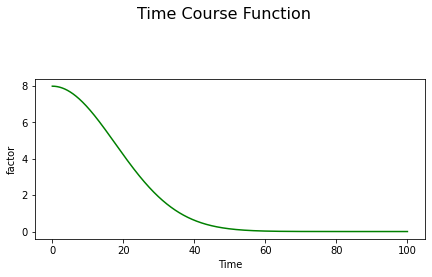

In [5]:
ts = np.arange(0, 100, 0.01)
y_lists = np.zeros_like(ts)
for i, t in enumerate(ts):
    y_lists[i] = t_course(t)

figure = plt.figure(figsize=(7, 10))
figure.suptitle('Time Course Function', fontsize=16)
r = figure.add_subplot(311)
r.plot(ts, y_lists, color='green')
r.set_ylabel("factor")
r.set_xlabel("Time")
plt.show()

In [6]:
class STDP:
    I1 = None
    I2 = None
    I3 = None
    t_list = []
    p = None

    def __init__(self, first_func: str, second_func: str, third_func: str):
        neuron_list = []
        p_size = 3
        s = 42
        np.random.seed(s)
        for i in range(p_size):
            neuron_list.append(LIF(10 + np.random.rand() * 3
                                   , 8 + np.random.rand() * 4
                                   , -79, -50, 5, -68))
        global p
        p = Population(p_type='exitatory', n_list=neuron_list, time_c=t_course)
        global I1
        I1 = lambda x: eval(first_func)
        global I2
        I2 = lambda x: eval(second_func)
        global I3
        I3 = lambda x: eval(third_func)
        input_current_list = [I1, I2, I3]

        p.running(I_lists=input_current_list,time_interval=50,
                  step=0.03125,dt_minus=6,dt_plus=10,a_minus=-4,
                  a_plus=+6, time_course_threshold=0.3)

        global t_list
        t_list = []
        time = 0
        step = 0.03125
        for i in range(len(p.c_history)):
            t_list.append(time)
            time += step

    @staticmethod
    def in_plot():
        figure = plt.figure(figsize=(15, 4))
        figure.suptitle('', fontsize=15)

        pt = figure.add_subplot(131)
        I = []
        for i in t_list:
            I.append(I1(i))
        pt.plot(t_list, I, color='green')
        pt.set_ylabel("Input")
        pt.set_xlabel("Time")
        pt.set_title('Neuron One')

        pt = figure.add_subplot(132)
        I = []
        for i in t_list:
            I.append(I2(i))
        pt.plot(t_list, I)
        pt.set_ylabel("Input")
        pt.set_xlabel("Time")
        pt.set_title('Neuron Two')

        pt = figure.add_subplot(133)
        I = []
        for i in t_list:
            I.append(I3(i))
        pt.plot(t_list, I)
        pt.set_ylabel("Input")
        pt.set_xlabel("Time")
        pt.set_title('Neuron Three')
        plt.show()

    @staticmethod
    def w_plotting():
        figure = plt.figure(figsize=(15, 10))
        figure.suptitle('Synaptic Weight Changes', fontsize=16)
        axes = plt.axes()
        axes.set_facecolor('cyan')




        plotting_figuration = figure.add_subplot(231)
        plotting_figuration.plot(t_list, p.c_history[:, 1], color='green')
        plotting_figuration.set_ylabel("Connection Weight(W(ij))")
        plotting_figuration.set_xlabel("Time")
        plotting_figuration.set_title('weight12')



        plotting_figuration = figure.add_subplot(232)
        plotting_figuration.plot(t_list, p.c_history[:, 2], color='green')
        plotting_figuration.set_ylabel("Connection Weight(W(ij))")
        plotting_figuration.set_xlabel("Time")
        plotting_figuration.set_title('weight13')


        plotting_figuration = figure.add_subplot(233)
        plotting_figuration.plot(t_list, p.c_history[:, 3], color='green')
        plotting_figuration.set_ylabel("Connection Weight(W(ij))")
        plotting_figuration.set_xlabel("Time")
        plotting_figuration.set_title('weight21')


        plotting_figuration = figure.add_subplot(234)
        plotting_figuration.plot(t_list, p.c_history[:, 5], color='green')
        plotting_figuration.set_ylabel("Connection Weight(W(ij))")
        plotting_figuration.set_xlabel("Time")
        plotting_figuration.set_title('weight23')


        plotting_figuration = figure.add_subplot(235)
        plotting_figuration.plot(t_list, p.c_history[:, 6], color='green')
        plotting_figuration.set_ylabel("Connection Weight(W(ij))")
        plotting_figuration.set_xlabel("Time")
        plotting_figuration.set_title('weight31')


        plotting_figuration = figure.add_subplot(236)
        plotting_figuration.plot(t_list, p.c_history[:, 7], color='green')
        plotting_figuration.set_ylabel("Connection Weight(W(ij))")
        plotting_figuration.set_xlabel("Time")
        plotting_figuration.set_title('weight32')
        plt.show()


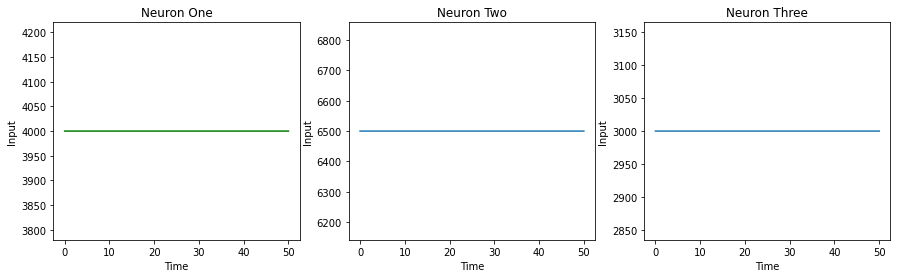

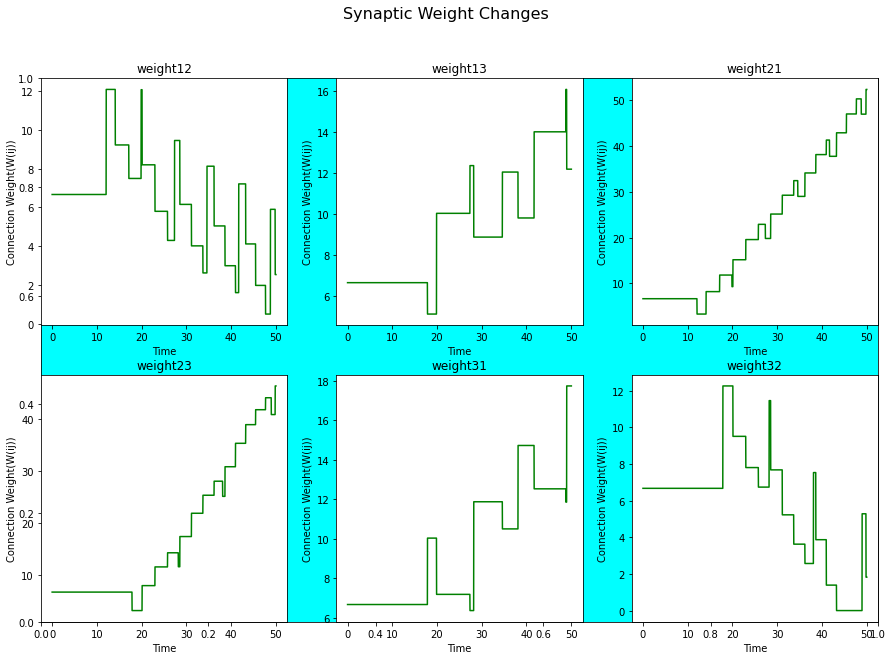

In [7]:
stdp_model = STDP("4000", "6500", "3000")
stdp_model.in_plot()
stdp_model.w_plotting()

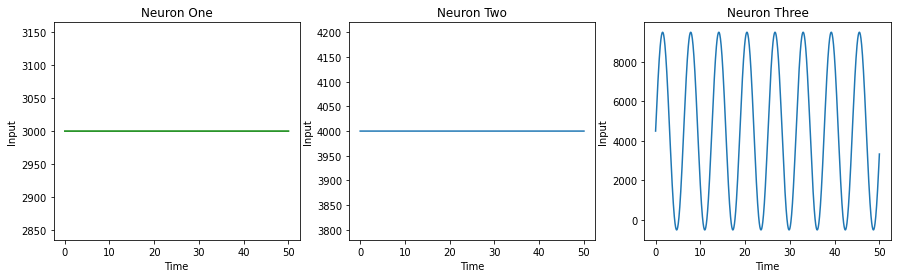

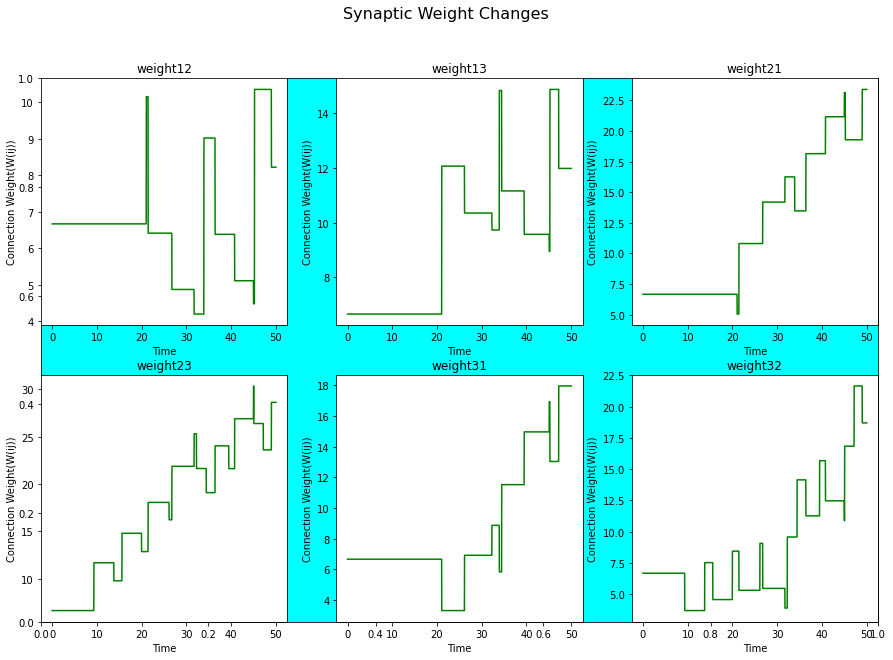

In [8]:
stdp_model = STDP("3000", "4000", "5000 * (math.sin(x) + 0.9)")
stdp_model.in_plot()
stdp_model.w_plotting()

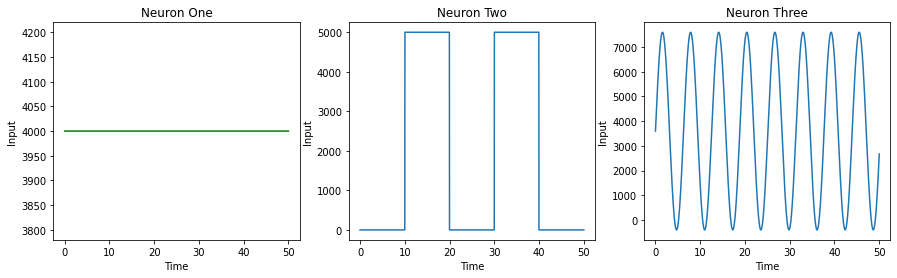

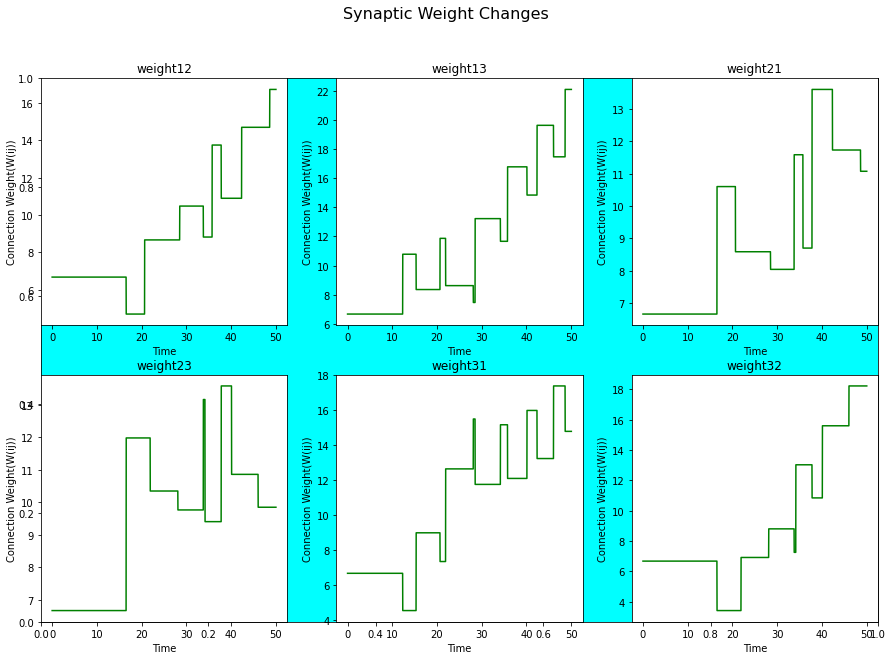

In [9]:
stdp_model = STDP("4000", "5000 if 10 < x < 20 or 30 < x < 40 else 0",
                  "4000 * (math.sin(x) + 0.9)")
stdp_model.in_plot()
stdp_model.w_plotting()

In [10]:
def snn_time_course(time, sigma=7, m=0):
    return 250 * (1 / (sigma * math.sqrt(2 * math.pi)))\
           * math.exp(-((time - m) / sigma) ** 2)

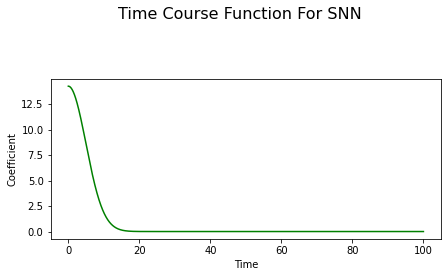

In [11]:
times = np.arange(0, 100, 0.01)
y = np.zeros_like(times)
for i, t in enumerate(times):
    y[i] = snn_time_course(t)

figure = plt.figure(figsize=(7, 10))
figure.suptitle('Time Course Function For SNN', fontsize=16)
res = figure.add_subplot(311)
res.plot(times, y, color='green')
res.set_ylabel("Coefficient")
res.set_xlabel("Time")
plt.show()


In [12]:
dataset = pd.read_excel ('./dataSet.xlsx')
AXIS_TRAIN = dataset.iloc[1:6, 1:].values.T * 10000
YIS_TRAIN = dataset.iloc[6, 1:].values
AXIS_TEST = dataset.iloc[10:15, 1:].values.T * 10000
YIS_TEST = dataset.iloc[15, 1:].values

In [13]:
np.random.seed(42)
lif_neuron_parameters = \
    {
        'R': 10,
        'tau': 8,
        'u_rest': -79,
        'threshold': -50,
        'u_spike': 5,
        'u_reset': -68,
        'random': True,
        'rand_change': 2
    }

network = SNN(n_dim=(5, 2), lif_n_parametr=lif_neuron_parameters,
              time_course=snn_time_course,tau_tag=15,tau_dopamine=15,reward=5)
network.compatible(AXIS_TRAIN,YIS_TRAIN, step=0.125,epoch_time=5,
                   step_minus=6,dt_plus=10,a_minus=-4,a_plus=+6,time_course_threshold=1,
                   iter=30, learn_time=0.5)

pred_TRAIN = network.forestall(AXIS_TRAIN, 5, 0.125, 1)
pred_Test = network.forestall(AXIS_TEST, 5, 0.125, 1)

from sklearn import metrics
print('accuracy of model for TEST data is: ', 100 *
      metrics.accuracy_score(YIS_TEST.astype(np.int32),
                             pred_Test.astype(np.int32)), '%')
print('accuracy of model for TRAIN data: ', 100 *
      metrics.accuracy_score(YIS_TRAIN.astype(np.int32),
                             pred_TRAIN.astype(np.int32)), '%')

accuracy of model for TEST data is:  40.0 %
accuracy of model for TRAIN data:  40.0 %
